In [2]:
import pandas as pd
import numpy as np

import geopandas as gpd
data_dir = './rawdatas/'

In [3]:
grid = gpd.read_file(data_dir + 'gb_grid/gb_grid.shp', encoding='utf-8')
# grid.plot()

- **종합병원 위치**

In [4]:
hos = pd.read_csv(data_dir+'1.병원정보서비스.csv')

hos = hos[hos['시도코드명']=='경북']
hos = hos[hos['종별코드명']=='종합병원']
hos = hos[['요양기관명', '종별코드명', '시도코드명', '시군구코드명', '읍면동', '좌표(X)', '좌표(Y)']]

hos = hos.reset_index(drop=True)
hos.head()

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,좌표(X),좌표(Y)
0,경상북도김천의료원,종합병원,경북,김천시,모암동,128.126439,36.122723
1,경상북도안동의료원,종합병원,경북,안동시,북문동,128.732112,36.568221
2,경상북도포항의료원,종합병원,경북,포항북구,용흥동,129.354941,36.034881
3,구미강동병원,종합병원,경북,구미시,진평동,128.422869,36.096239
4,동국대학교의과대학경주병원,종합병원,경북,경주시,석장동,129.196658,35.858308


In [5]:
hos_geo = gpd.GeoDataFrame(data=hos, geometry=gpd.points_from_xy(hos['좌표(X)'], hos['좌표(Y)']),
                 crs='epsg:4326')
hos_geo.head()

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,좌표(X),좌표(Y),geometry
0,경상북도김천의료원,종합병원,경북,김천시,모암동,128.126439,36.122723,POINT (128.12644 36.12272)
1,경상북도안동의료원,종합병원,경북,안동시,북문동,128.732112,36.568221,POINT (128.73211 36.56822)
2,경상북도포항의료원,종합병원,경북,포항북구,용흥동,129.354941,36.034881,POINT (129.35494 36.03488)
3,구미강동병원,종합병원,경북,구미시,진평동,128.422869,36.096239,POINT (128.42287 36.09624)
4,동국대학교의과대학경주병원,종합병원,경북,경주시,석장동,129.196658,35.858308,POINT (129.19666 35.85831)


In [6]:
gb_sgg = gpd.read_file(data_dir+'LARD_ADM_SECT_SGG_경북/LARD_ADM_SECT_SGG_47_202403.shp', encoding='cp949')
gb_sgg = gb_sgg.to_crs('epsg:4326')

<Axes: >

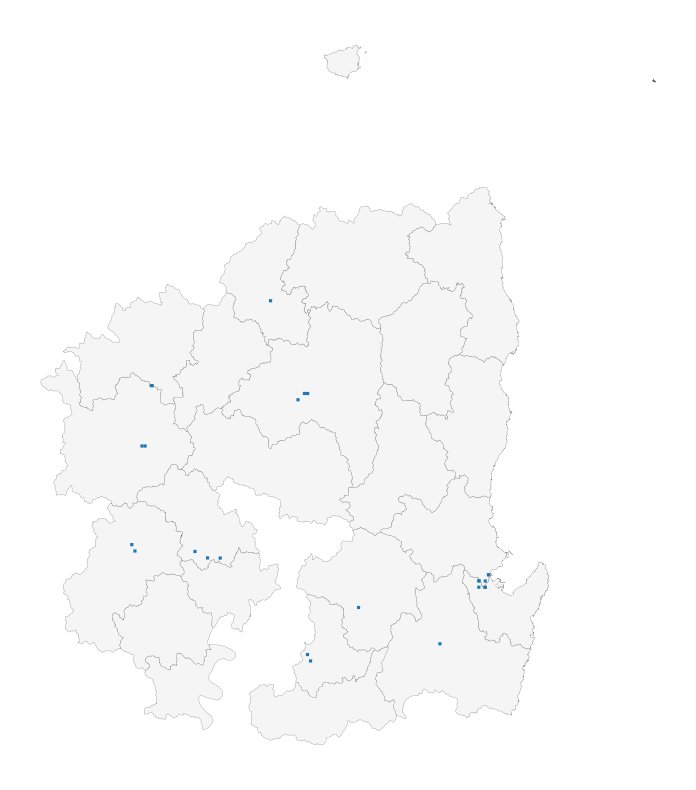

In [7]:
# ax = grid.plot(figsize=(20, 20), color='whitesmoke', linewidth=0.1, edgecolor='black')
ax = gb_sgg.plot(figsize=(10, 10), color='whitesmoke', edgecolor='black', linewidth=0.1)
ax.axis('off')
# hos_geo.plot(ax=ax, color='deepskyblue', markersize=10, marker=',') # 종합병원 포인트 표시 

gpd.sjoin(grid, hos_geo).plot(ax=ax)

- 클러스터링 결과 투영

In [13]:
sgg_cls = pd.read_csv('sgg_clusters.csv')
sgg_cls = sgg_cls.iloc[:, 1:]
sgg_cls.head()

,SGG_NM,Cluster
0,포항시 남구,1
1,포항시 북구,1
2,경주시,1
3,김천시,2
4,안동시,2


In [16]:
gb_sgg_with_cls = gb_sgg.copy()
gb_sgg_with_cls = pd.merge(gb_sgg_with_cls, sgg_cls, how='left', on='SGG_NM')
gb_sgg_with_cls.head()

,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,geometry,Cluster
0,47111,포항시 남구,1,47110,"MULTIPOLYGON (((129.57924 36.05416, 129.57949 ...",1
1,47113,포항시 북구,2,47110,"MULTIPOLYGON (((129.28207 36.33205, 129.28261 ...",1
2,47130,경주시,2,47130,"POLYGON ((128.97136 35.75713, 128.97196 35.758...",1
3,47150,김천시,51,47150,"MULTIPOLYGON (((128.25930 36.20308, 128.25935 ...",2
4,47170,안동시,370,47170,"MULTIPOLYGON (((128.42916 36.52273, 128.43020 ...",2


<Axes: >

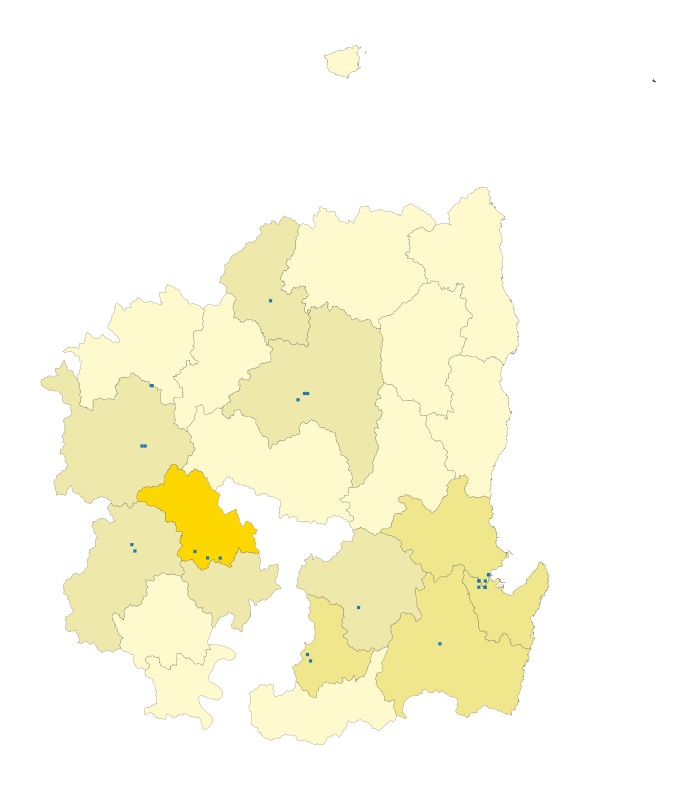

In [25]:
color_mapping = {0: 'lemonchiffon', 2: 'palegoldenrod', 1: 'khaki', 3: 'gold'}
ax = gb_sgg_with_cls.plot(figsize=(10, 10), edgecolor='black', linewidth=0.1,
                          color=gb_sgg_with_cls['Cluster'].map(color_mapping))
ax.axis(False)
gpd.sjoin(grid, hos_geo).plot(ax=ax)

-> 0 클러스터 권역에는 종합병원이 위치하지 않은 것을 확인할 수 있음.

- **도로교통망**

In [32]:
gb_link = gpd.read_file(data_dir+'gb_link/GB_LINK.shp')
gb_link = gb_link.to_crs('epsg:4326')

link_in_grid = gpd.sjoin(grid, gb_link) # ->도로가 있는 격자

<Axes: >

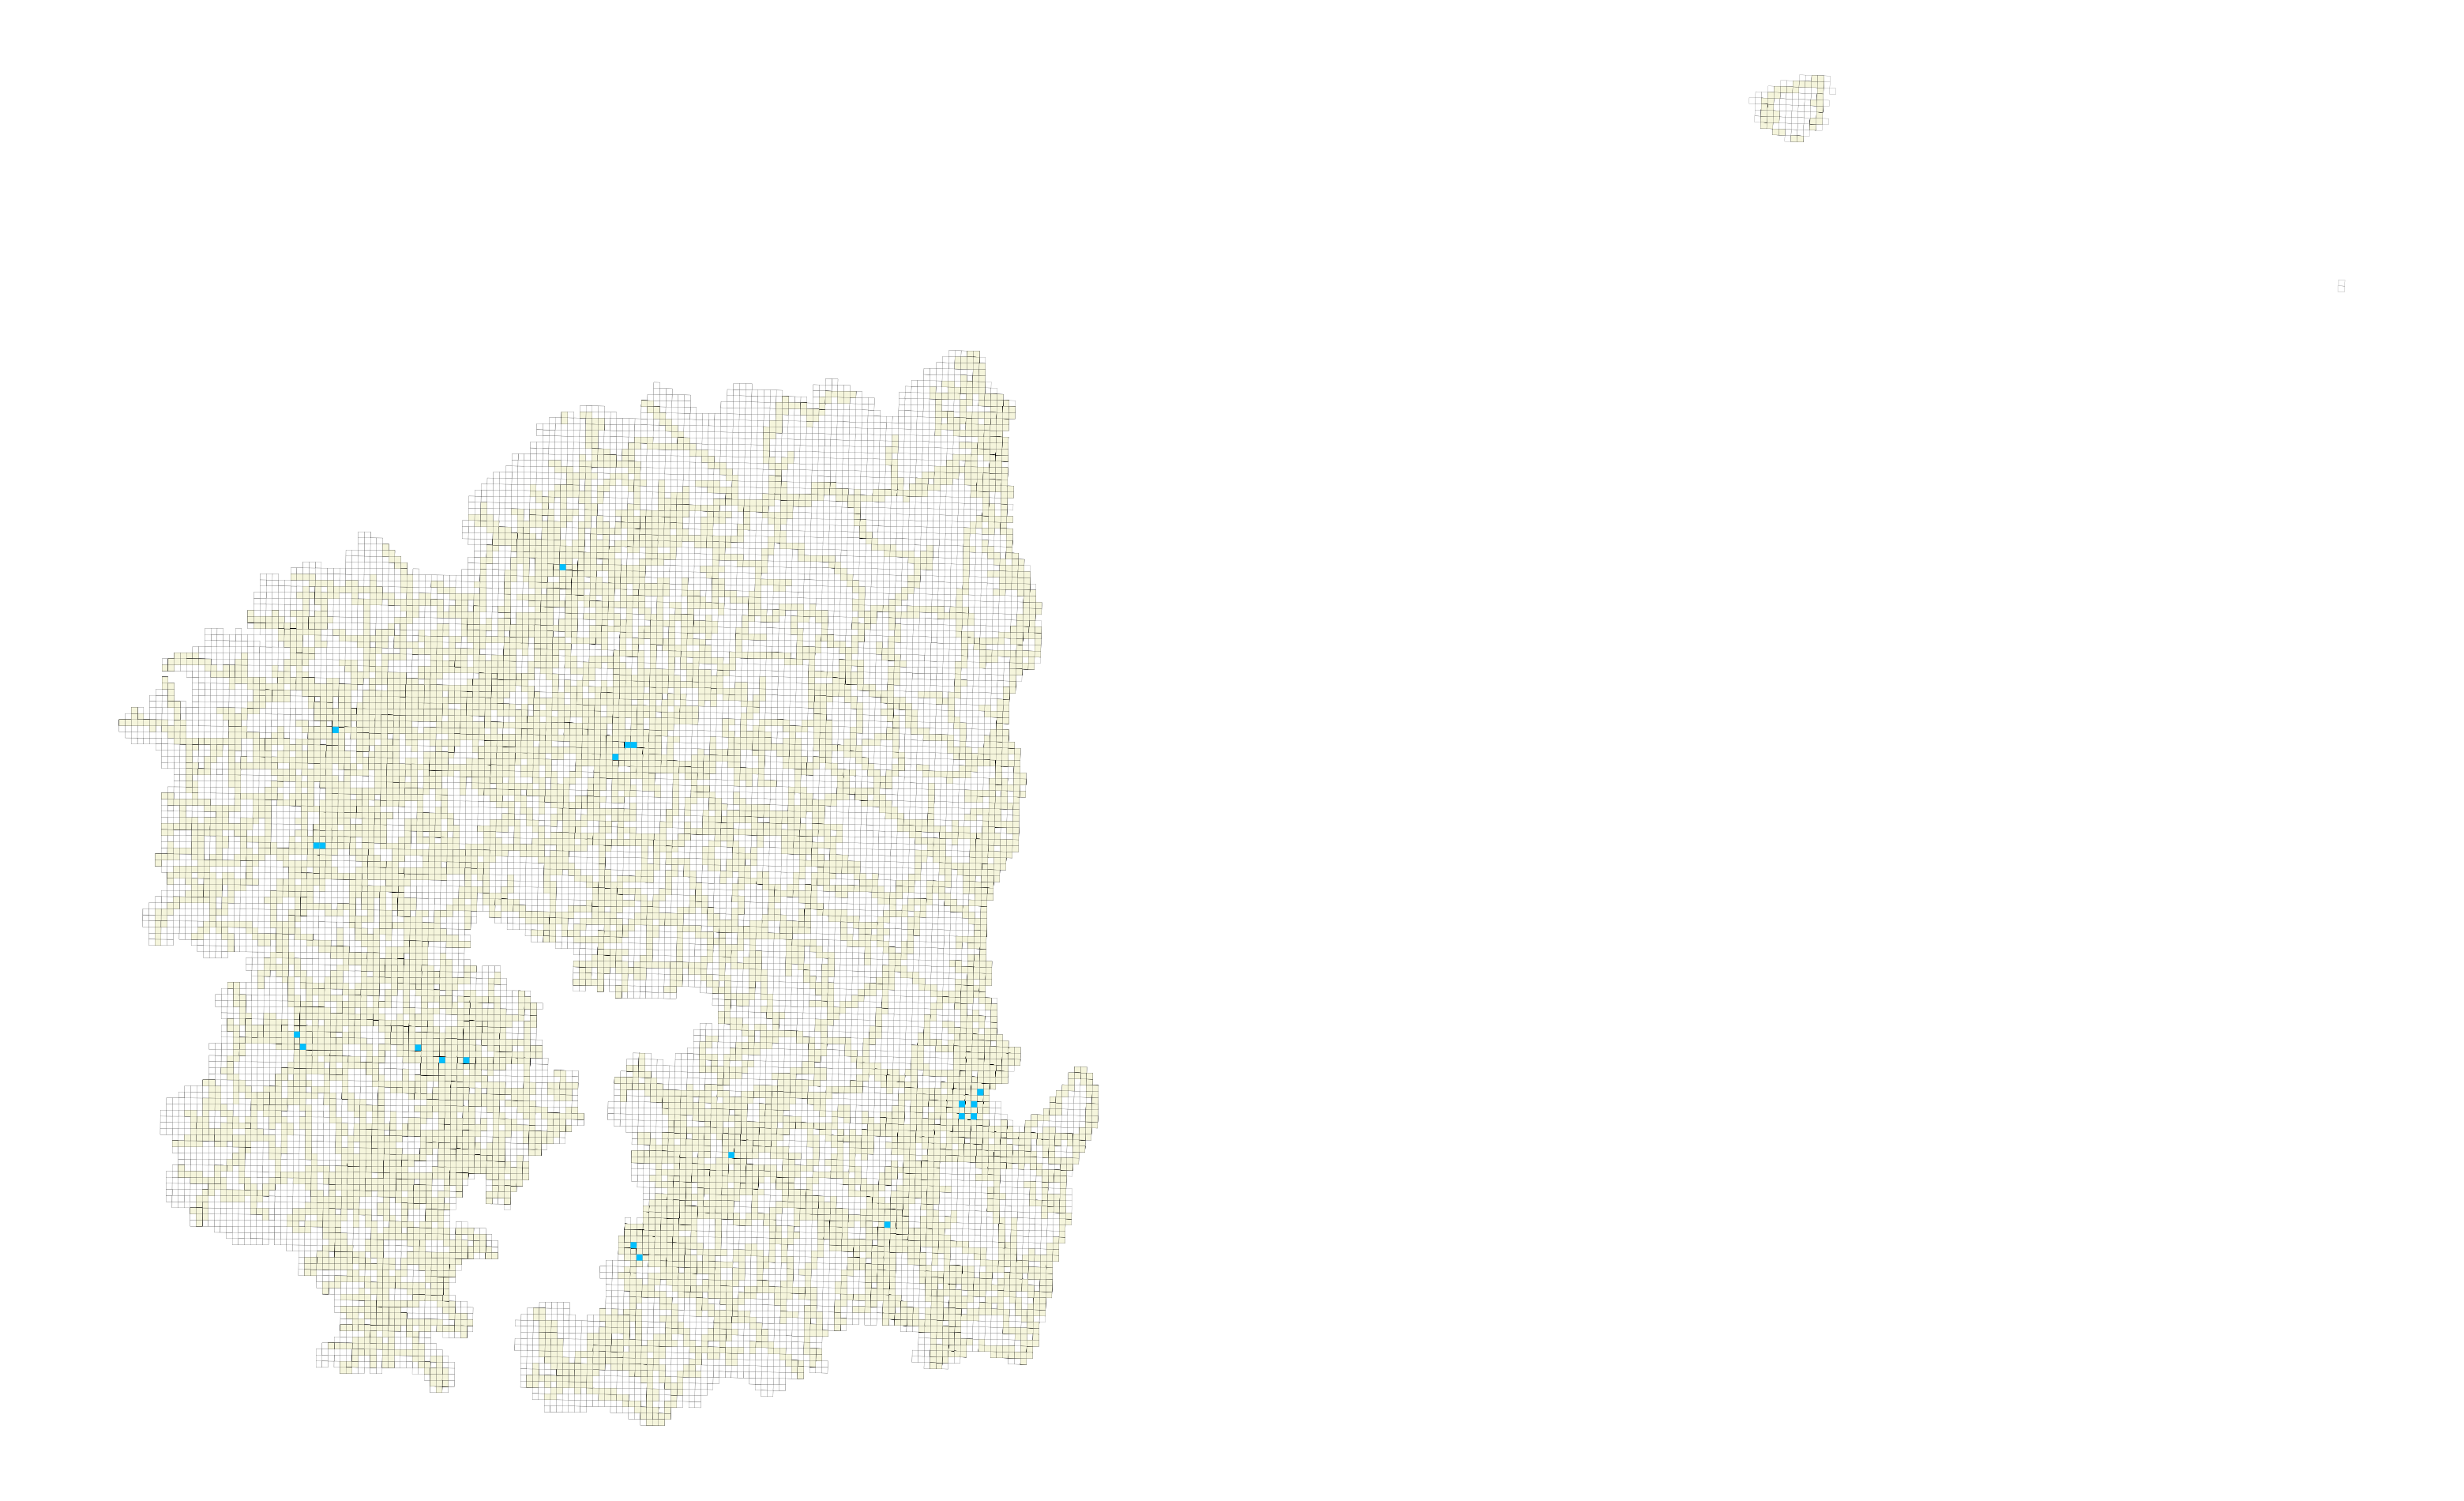

In [40]:
ax = grid.plot(figsize=(40, 40), color='white', linewidth=0.1, edgecolor='black')
ax.axis('off')

link_in_grid.plot(ax=ax, color='beige', linewidth=0.1, edgecolor='black')
gpd.sjoin(grid, hos_geo).plot(ax=ax, color='deepskyblue')

- **0 클러스터 격자 추출**

<Axes: >

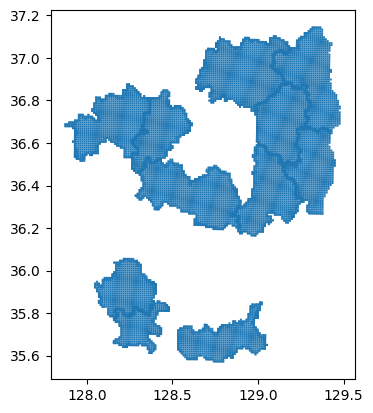

In [45]:
grid_cluster_0 = gpd.sjoin(grid, gb_sgg_with_cls[gb_sgg_with_cls['Cluster']==0])
grid_cluster_0.plot()

- **지형지물**

<Axes: >

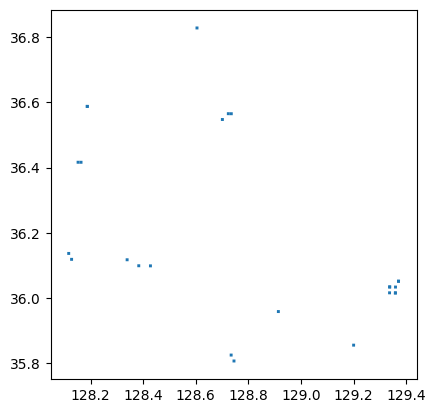

In [9]:
gpd.sjoin(grid, hos_geo).plot() # grid에서 종합병원 POINT가 있는 격자만 추출

In [10]:
import os
os.listdir(data_dir)

['1.병원정보서비스.csv',
 '153.1 종합병원(읍면동) 서비스권역 외 취약인구비율(5.0km)_2022.msld',
 '3.의료기관별상세정보서비스_01_시설정보.csv',
 'gb_geos.geojson',
 'gb_grid',
 'HangJeongDong_ver20230701.geojson',
 'integrated_for_clst_(1).csv',
 'LARD_ADM_SECT_SGG_경북',
 'nlsp_020001010.msld',
 'sig_20230729',
 '건강보험심사평가원_병원급이상 진료과목별 시도별 진료비 통계_20221231.csv',
 '건강보험심사평가원_의료기관 시군구별 진료비 통계_20221231.csv',
 '건강보험심사평가원_전문병원 지정 현황_20210101.csv',
 '보건복지부_공공보건 의료기관 현황_20161231.csv',
 '빈격자1km',
 '시·군·구별_연간_미충족의료율_병의원__20240411154120_1레벨.csv',
 '시도별_공공의료기관_비중_20240411163247.csv',
 '인구, 가구 및 주택 – 읍면동(연도 끝자리 0, 5), 시군구(그 외 연도).csv',
 '인구_1000명당_의사수.csv',
 '전국 병의원 및 약국 현황 2023.12',
 '지역별종별_의료인력현황_의사등_2022년4분기.csv',
 '행정구역_읍면동_별_5세별_주민등록인구_2011년__20240414151259.csv',
 '행정안전부_병원_20240302.csv']